# Running a Outlet-Outfall Simulation [1]
### Importing required packages and libraries
A Outlet-Outfall simulation is a model of IWS that includes the filling process and models consumers with a flow-restricted withdrawal 
In this notebook, we use PySWMM (a python wrapper for EPA's SWMM) to run a pre-prepared SWMM .inp file  
Alternatively, the .inp file can be run from SWMM's GUI if preferred and the output (.out) file can be imported directly for post-processing
**The packages and libraries to be imported are:**  
* **PySWMM** for parsing, running and outputting the results of a SWMM .inp file
* **LinkAttribute**, a module in PySWMM that extracts a specific attribute from the output results
* **Pandas & Numpy** for data handling and processing
* **datetime** for parsing and operating on datetime formats
* **re** for usign regular expressions to filter the results
* **matplotlib** for plotting and visulisation

In [1]:
import pyswmm
import re
from swmm.toolkit.shared_enum import LinkAttribute
import pandas as pd
import numpy as np
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

### Specifying paths for simulation files and preprocessing the input
**Warning:** *Paths in this script (and the rest of this repo) are absolute unless running the network files provided within the repo*  
Input filename (with extensions) as string.  
For running the .inp files in this repository, you can use this relative path `"../../Network-Files/Network X/"` where X is the network number 

In [2]:
 # Replace with appropriate path and filename
directory='../../Network-Files/Network 3/'
filename='Network3_4hr_Outlet-Outfall.inp'
name_only=filename[0:-4]
print("Selected File: ",name_only)
abs_path=directory+filename

Selected File:  Network3_4hr_Outlet-Outfall


### Parsing .inp file and building the network model
PySWMM's Simulation module reads in a SWMM .inp file, parses it, and builds a network model object of the specified network  
SWMM typically produces a report file (containing specified reported results) and an output file (containing all results at all reporting time steps)  
PySWMM optionally allows for a path to be specified for each of those files, here we only need the output file (.out)

In [3]:
sim=pyswmm.Simulation(inputfile=abs_path, outputfile=directory+name_only+".out")


 o  Retrieving project data

### Preprocessing
In an Outlet-Outfall simulation, each demand node is outfitted with a fictitious outlet link, which discharges the demand into an outfall  
To later filter the results to include only the demand nodes, the IDs of the demand outlets are recorded

In [4]:
links=pyswmm.links.Links(sim)   #object containing links in the network model
demand_links=[]                 # Empty list for storing link ids

for link in links:
    # if link starts with OUT then it's an outlet and store its id
    if re.search('^Outlet',link.linkid):
        demand_links.append(link.linkid)

### Running the SWMM simulation
PySWMM has two modes of running a SWMM simulation  
In this mode, we step through the simulation step by step, which allows for (if needed) displaying key information while the simulation runs  
e.g., you may want to check on a specific node's depth while the simulation runs  
In this case, we only display the simulations current time, to give the user a sense of how long it is going to take  
You may edit the upcoming cell to print any other information you want (refer to pyswmm's documentation [here](https://pyswmm.readthedocs.io/en/stable/))  
To get more frequent current time outputs, reduce the value of **every** (More frequent updates -> longer runtime)

In [5]:
stp=0       #steps counter
every=1000  #Interval of printing current time

# runs the simulation step by step
with sim as sim:
    for step in sim:
        if stp%every==0:
            print('Current Time is >> ',sim.current_time)
        stp+=1
        pass

Current Time is >>  2022-05-18 00:00:01
Current Time is >>  2022-05-18 00:16:41
Current Time is >>  2022-05-18 00:33:21
Current Time is >>  2022-05-18 00:50:01
Current Time is >>  2022-05-18 01:06:41
Current Time is >>  2022-05-18 01:23:21
Current Time is >>  2022-05-18 01:40:01
Current Time is >>  2022-05-18 01:56:41
Current Time is >>  2022-05-18 02:13:21
Current Time is >>  2022-05-18 02:30:01
Current Time is >>  2022-05-18 02:46:41
Current Time is >>  2022-05-18 03:03:21
Current Time is >>  2022-05-18 03:20:01
Current Time is >>  2022-05-18 03:36:41
Current Time is >>  2022-05-18 03:53:21


### Postprocessing & Extracting the Results
Using the Output module in PySWMM, we extract the time series results for each  of the demand nodes  
Demand withdrawn is found as the flowrate going through the outlet attached to the original demand node   
IF YOU RUN THE PREVIOUS CELLS ONCE, YOU CAN SKIP THE PREVIOUS CELLS AND START HERE

In [6]:
actual_demands=pd.DataFrame()  #Empty Dataframe to store demand rates
swtch=True              # switch variable for upcoming condition

# Reads the output file created above
with pyswmm.Output(directory+name_only+".out") as out:
    # loops through each link in output file
    for link in out.links:

        # One time only. Gets the timesteps (the keys in the output series dictionary) and stores them to be used as index
        if swtch:
            # link_series produces a dictionary with the keys corresponding to timestamps and values contain the value of the selected variable (FLOW_RATE) at each timestamp
            index=pd.Series(out.link_series(link,LinkAttribute.FLOW_RATE).keys())
            actual_demands.loc[:,"time"]=index
            swtch=False
        # If link id is in the prepared list of demand links (outlets)
        if link in demand_links:
            # gets the values of the flow rate series dictionary and stores as a Pandas Series
            actual_demands.loc[:,link]=out.link_series(link,LinkAttribute.FLOW_RATE).values()


Cleaning up the dataframe for further processing  
SWMM output files skip the initial time step in reporting the results. These have to be added back manually.  
The time stamp output of PySWMM is of datetime format, and is subsequently converted to seconds from start of simulation

In [7]:
# Stores the start time stamp of the simulation
start_time=index[0]
# List to store index of time in seconds (0 added as the missing initial time step)
new_index=[]

# Loops through old index (datetime)
for time in index:
    # Gets time difference in seconds
    timesec=(time-start_time).seconds
    # Appends time in seconds to new index
    new_index.append(timesec+10)

actual_demands["time"]=new_index
actual_demands.set_index("time",inplace=True)
### Formatting the DataFrame to add a zero row at the beginning (for the initial time step) and fix index and column names
actual_demands.loc[0,:]=0
actual_demands.sort_index(inplace=True)


supply_duration=new_index[-1]/60
reporting_step=new_index[1]-new_index[0]

### FRW-specific Processing
For FRW methods, volumes are not a direct output of the simulation, but instead are calculated based on demands withdrawn at all time steps  
This is not required for VRW methods 

In [8]:
# Calculates the total demand volume in the specified supply cycle
desired_volumes=[]
demand_rates=pd.read_csv(directory+name_only+"_Demands.csv")
demand_rates.set_index("ID",inplace=True)

# Loop over each desired demand
for demand in demand_rates["Demand"]:
    # Append the corresponding desired volume (cum) = demand (LPS) *60 sec/min * supply duration (hr) / 1000 (L/cum)
    desired_volumes.append(float(demand)*60*float(supply_duration))

# Combine demands (LPS) to their corresponding desired volume (cum)
desired_volumes=dict(zip(demand_links,desired_volumes))

# Initalized DataFrame for storing volumes received by each demand node as a timeseries
timesrs_satisfaction=pd.DataFrame(index=actual_demands.index,columns=desired_volumes.keys())
# Set Initial volume for all consumers at 0
timesrs_satisfaction.iloc[0,:]=0

# Loop over consumers and time steps to add up volumes as a percentage of total desired volume (Satisfaction Ratio)
for timestep in list(timesrs_satisfaction.index)[1:]:
    for node in timesrs_satisfaction.columns:
        # Cummulatively add the percent satisfaction ratio (SR) increased each time step
        ## SR at time t = SR at time t-1 + demand at time t-1 (cms) *60 seconds per time step/ Desired Demand Volume (cum)
        timesrs_satisfaction.at[timestep,node]=timesrs_satisfaction.at[timestep-reporting_step,node]+actual_demands.at[timestep-reporting_step,node]*reporting_step/1000/desired_volumes[node]

### Calculating Consumer Satisfaction Statistics
To get a better grasp of how the demands were distributed among consumers, we calculate some descriptive stats at each time step  
**Mean Satisfaction** describes the average state throughout the network, only reaches 100 if all demands are satisfied  
**Low percentile, Median, and High Percentile** at each time step for a sense of the shape of the distribution (for equality considerations) with time  
Choose the low percentile number desired (e.g., 10<sup>th</sup> percentile) and the high percentile (e.g., 90<sup>th</sup> Percentile) by changing their respective values below 

In [9]:
# Intialize Series for storing statistics
mean=pd.Series(dtype='float64')
median=pd.Series(dtype='float64')
low_percentile=pd.Series(dtype='float64')
high_percentile=pd.Series(dtype='float64')

# Set the percentile values to be calculated
low_percent_val=10   # Range 0 to 100 ONLY
high_percent_val=90  # Range 0 to 100 ONLY

# Loop over each row (time step) in the results and calculate values of mean, median, low and high percentiles
for row in timesrs_satisfaction.index:
    mean.loc[row]=np.mean(timesrs_satisfaction.loc[row,:])*100
    low_percentile.loc[row]=np.percentile(timesrs_satisfaction.loc[row,:],low_percent_val)*100
    median.loc[row]=np.percentile(timesrs_satisfaction.loc[row,:],50)*100
    high_percentile.loc[row]=np.percentile(timesrs_satisfaction.loc[row,:],high_percent_val)*100

### (Optional) Save .csv files with  Results & Stats
Comment out any files you do not need, or skip this cell entirely if you don't want any files saved to your local device

In [11]:
# Saves Entire Results DataFrame as Filename_TimeSeries.csv in the same path
timesrs_satisfaction.to_csv(directory+name_only+"_TimeSeries.csv")

# Saves Mean Satisfaction with time as Filename_Means.csv in the same path
mean.to_csv(directory+name_only+"_Means.csv")

# Saves Median Satisfaction with time as Filename_Medians.csv in the same path
median.to_csv(directory+name_only+"_Medians.csv")

# Saves the specified low percentile (XX) values with time as Filename_XXthPercentile.csv in the same path
low_percentile.to_csv(directory+name_only+"_"+str(low_percent_val)+"thPercentile.csv")

# Saves the specified high percentile (YY) values with time as Filename_YYthPercentile.csv in the same path
high_percentile.to_csv(directory+name_only+"_"+str(high_percent_val)+"thPercentile.csv")

### Calculating Filling Time

In [10]:
filling_times=pd.DataFrame(index=timesrs_satisfaction.columns, columns=["Arrival Time (hr)","Pressurization Time (hr)","Satisfaction Time (hr)"])
for node in timesrs_satisfaction.columns:
    arrival_swtch=True
    press_swtch=True
    satis_swtch=True
    for time in timesrs_satisfaction.index:
        if timesrs_satisfaction.at[time,node]>0 and arrival_swtch:
            filling_times.at[node,"Arrival Time (hr)"]=time/3600
            arrival_swtch=False
        percent_diff=abs(actual_demands.at[time,node]-demand_rates.at[node,"Demand"]*1000)/(demand_rates.at[node,"Demand"]*1000)
        if  percent_diff<0.001 and press_swtch:
            filling_times.at[node,"Pressurization Time (hr)"]=time/3600
            press_swtch=False
        if timesrs_satisfaction.at[time,node]>0.999 and satis_swtch:
            filling_times.at[node,"Satisfaction Time (hr)"]=time/3600
            satis_swtch=False

# Optional Saving CSV
filling_times.to_csv(directory+name_only+"_FillingTimes.csv")

## Result Visualisation
### Demand Satisfaction
First we plot the Mean satisfaction in the network with time

<function matplotlib.pyplot.show(close=None, block=None)>

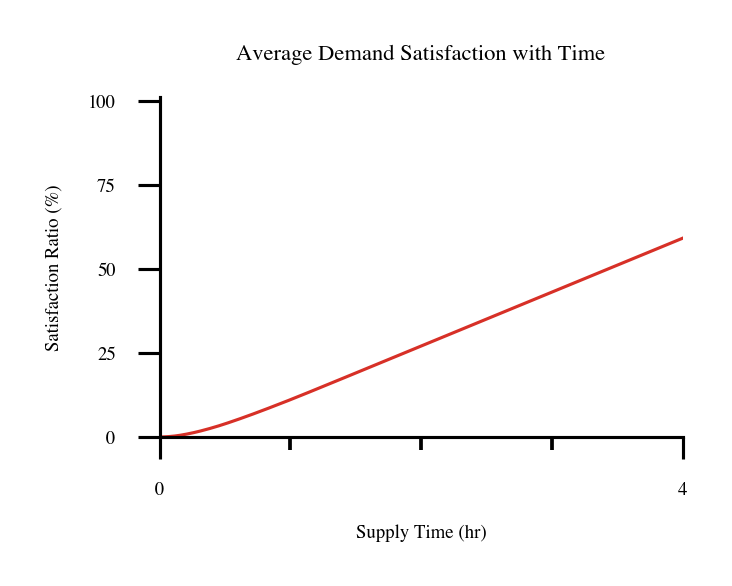

In [11]:
# Setting Universal Parameters for plotting: dots per inch (dpi), text font and size, label size
mpl.rcParams['figure.dpi'] = 450
font = {'family' : 'Times',
        'weight' : 'bold',
        'size'   : 3}
mpl.rc('font', **font)
mpl.rc('xtick', labelsize=3)
mpl.rcParams['axes.linewidth'] = 0.5

# Prepping an xaxis with hr format
supply_duration_hr=supply_duration/60
xaxis=[x/3600 for x in actual_demands.index]

fig, ax=plt.subplots()
# Change figure size (and aspect ratio) by adjusting height and width here
fig.set_figwidth(1.5)
fig.set_figheight(1)

# Formatting Plot: Setting a Title, x- and y-axis limits, major and minor ticks
ax.set_title('Average Demand Satisfaction with Time')
ax.set_xlim(0,supply_duration_hr)
ax.set_ylim(0,101)
ax.set_xticks(np.arange(0,supply_duration_hr+1,4))
ax.set_xticks(np.arange(0,supply_duration_hr+1,1),minor=True)
ax.set_yticks(np.arange(0,101,25))
ax.tick_params(width=0.5)

# Data to be plotted: Mean as a percentage (hence the multiplication by 100)
# Change color by changing the string next to c= and linewidth by value
line1,=ax.plot(xaxis,mean, c='#d73027',linewidth=0.5)
plt.xlabel('Supply Time (hr)')
plt.ylabel('Satisfaction Ratio (%)')
# Optional: show grid or turn on and off spines (Plot box sides)
# ax.grid(visible=True,which='both')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show

### Plotting the Distribution between Consumers (Equality)
Low Percentile, Median and High Percentile are plotted together to show the distribution between consumers with time. Area between Low and High Percentiles will be shaded

<function matplotlib.pyplot.show(close=None, block=None)>

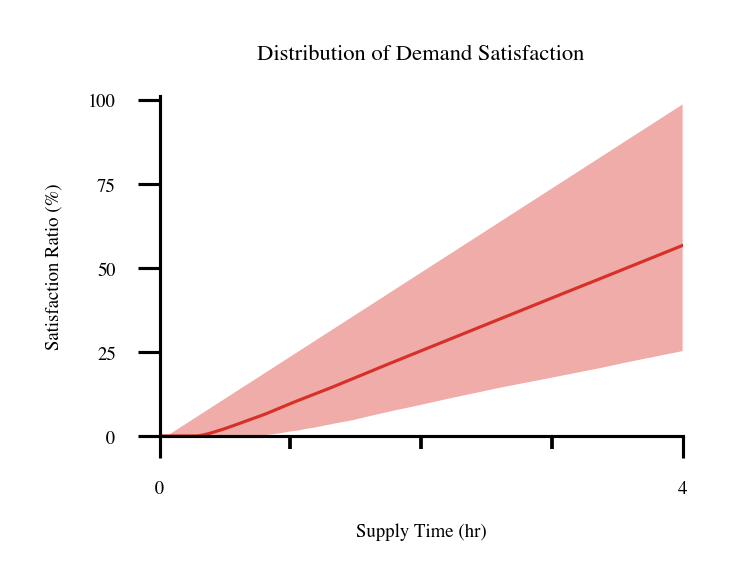

In [12]:
fig, ax=plt.subplots()
# Change figure size (and aspect ratio) by adjusting height and width here
fig.set_figwidth(1.5)
fig.set_figheight(1)

# Formatting Plot: Setting a Title, x- and y-axis limits, major and minor ticks
ax.set_title('Distribution of Demand Satisfaction')
ax.set_xlim(0,supply_duration_hr)
ax.set_ylim(0,101)
ax.set_xticks(np.arange(0,supply_duration_hr+1,4))
ax.set_xticks(np.arange(0,supply_duration_hr+1,1),minor=True)
ax.set_yticks(np.arange(0,101,25))
ax.tick_params(width=0.5)


# Data to be plotted: Mean as a percentage (hence the multiplication by 100)
# Change color by changing the string next to c= and linewidth by value
line1,=ax.plot(xaxis,median, c='#d73027',linewidth=0.5)
plt.fill_between(xaxis, y1=low_percentile, y2=high_percentile, alpha=0.4, color='#d73027', edgecolor=None)
plt.xlabel('Supply Time (hr)')
plt.ylabel('Satisfaction Ratio (%)')
# Optional: show grid or turn on and off spines (Plot box sides)
# ax.grid(visible=True,which='both')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show

### Visualising Filling Times

### References:
##### [1] A. Campisano, A. Gullotta, and C. Modica, “Using EPA-SWMM to simulate intermittent water distribution systems,” Urban Water Journal, vol. 15, no. 10, pp. 925–933, Nov. 2018, doi: 10.1080/1573062X.2019.1597379.